## Libraries

In [ ]:
!pip install control

In [ ]:
import numpy as np
import torch
import random
import control as ct
from collections import deque

## Model Architecture

### Actor Network

In [ ]:
class Actor(torch.nn.Module):
  def __init__(self, state_dim, action_dim, max_action=1) -> None:
    super(Actor, self).__init__()

    self.l1 = torch.nn.Linear(state_dim, 128)
    self.l2 = torch.nn.Linear(128, 128)
    self.l3 = torch.nn.Softplus(128, action_dim)

    self.max_action = max_action


  def forward(self, state):
    a = torch.relu(self.l1(state))
    a = torch.relu(self.l2(a))
    return self.max_action * self.l3(a)

### Critic Network

In [ ]:
class Critic(torch.nn.Module):
  def __init__(self, state_dim, action_dim) -> None:
    super(Critic, self).__init__()

    # Q1 architecture
    self.l1 = torch.nn.Linear(state_dim + action_dim, 128)
    self.l2 = torch.nn.Linear(128, 128)
    self.l3 = torch.nn.Linear(128, 1)

    # Q2 architecture
    self.l4 = torch.nn.Linear(state_dim + action_dim, 128)
    self.l5 = torch.nn.Linear(128, 128)
    self.l6 = torch.nn.Linear(128, 1)

  def forward(self, state, action):
    sa = torch.cat([state, action], 1)
    q1 = torch.relu(self.l1(sa))
    q1 = torch.relu(self.l2(q1))
    q1 = self.l3(q1)

    q2 = torch.relu(self.l4(sa))
    q2 = torch.relu(self.l5(q2))
    q2 = self.l6(q2)

    return q1, q2

  def Q1(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = torch.relu(self.l1(sa))
        q1 = torch.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


### Replay Buffer

In [ ]:
class ReplayBuffer:
  def __init__(self, max_size=1e6):
    self.buffer = deque(maxlen=int(max_size))

  def push(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size=32):
    state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
    return (
        torch.tensor(state, dtype=torch.float32),
        torch.tensor(action, dtype=torch.float32),
        torch.tensor(reward, dtype=torch.float32).unsqueeze(1),
        torch.tensor(next_state, dtype=torch.float32),
        torch.tensor(done, dtype=torch.float32).unsqueeze(1)
    )

  def __len__(self):
    return len(self.buffer)

### TD3

In [ ]:
class TD3:
  def __init__(self, state_dim, action_dim, max_action=1):
    self.actor = Actor(state_dim, action_dim, max_action)
    self. actor_target = Actor(state_dim, action_dim, max_action)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

    self.critic = Critic(state_dim, action_dim)
    self.critic_target = Critic(state_dim, action_dim)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

    self.replay_buffer = ReplayBuffer()

    self.total_it = 0

    # Hyperparameters
    self.tau = 0.005
    self.gamma = 0.99
    self.policy_noise = 0.2
    self.noise_clip = 0.5
    self.policy_freq = 2
    self.batch_size = 32

    def select_action(self, state, noise=0):
      state = torch.tensor(state.reshape(1, -1), dtype=torch.float32)
      action = self.actor(state).data.numpy().flatten()
      return action

    def train(self):
      self.total_it += 1
      state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

      with torch.no_grad():
        next_action = self.actor_target(next_state)

        # Compute target Q values
        target_Q1, target_Q2 = self.critic_target(next_state, next_action)
        target_Q = torch.min(target_Q1, target_Q2)
        target_Q = reward + (1 - done) * self.gamma * target_Q

      current_Q1, current_Q2 = self.critic(state, action)

      # Compute critic loss
      critic_loss = torch.nn.F.mse_loss(current_Q1, target_Q) + torch.nn.F.mse_loss(current_Q2, target_Q)

      # Optimize the critic
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      # Delayed policy updates
      if self.total_it % self.policy_freq == 0:
          # Compute actor loss
          actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

          # Optimize the actor
          self.actor_optimizer.zero_grad()
          actor_loss.backward()
          self.actor_optimizer.step()

          # Update target networks
          for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
              target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

          for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
              target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])


## Environment

### Quadcopter

In [ ]:
class Quadcopter:
    def __init__(self, m, Ixx, Iyy, Izz, g):
        self.m = m
        self.Ixx = Ixx
        self.Iyy = Iyy
        self.Izz = Izz
        self.g = g

        # Initialize 12 states: [x,x_dot,y,y_dot,z,z_dot,phi,phi_dot,theta,theta_dot,psi,psi_dot]
        self.states = np.zeros(12)

        # Initialize 4 actions: [T, tau_roll, tau_pitch, tau_yaw]
        self.actions = np.zeros(4)

    def update_states(self, dt):
        """
        Update the quadcopter states based on current states and actions.
        dt: time step
        """
        # Extract states
        x, y, z, x_dot, y_dot, z_dot, phi, theta, psi, phi_dot, theta_dot, psi_dot = self.states

        # Extract actions
        T, tau_phi, tau_theta, tau_psi = self.actions

        # Gravity vector
        g = self.g

        # Rotation matrix from body to inertial frame (Z-Y-X Euler angles)
        cphi, sphi = np.cos(phi), np.sin(phi)
        ctheta, stheta = np.cos(theta), np.sin(theta)
        cpsi, spsi = np.cos(psi), np.sin(psi)

        # Simplified rotation matrix elements for acceleration
        ax = -(stheta) * T / self.m
        ay = (sphi * ctheta) * T / self.m
        az = (cphi * ctheta) * T / self.m - g

        # Linear accelerations (update velocities)
        x_dot_dot = ax
        y_dot_dot = ay
        z_dot_dot = az

        # Angular accelerations
        phi_dot_dot = tau_phi / self.Ixx
        theta_dot_dot = tau_theta / self.Iyy
        psi_dot_dot = tau_psi / self.Izz

        # Update states using Euler integration
        # Position
        self.states[0] += x_dot * dt  # x
        self.states[1] += y_dot * dt  # y
        self.states[2] += z_dot * dt  # z

        # Velocity
        self.states[3] += x_dot_dot * dt  # x_dot
        self.states[4] += y_dot_dot * dt  # y_dot
        self.states[5] += z_dot_dot * dt  # z_dot

        # Angles
        self.states[6] += phi_dot * dt    # roll
        self.states[7] += theta_dot * dt   # pitch
        self.states[8] += psi_dot * dt     # yaw

        # Angular velocities
        self.states[9] += phi_dot_dot * dt   # roll_dot
        self.states[10] += theta_dot_dot * dt # pitch_dot
        self.states[11] += psi_dot_dot * dt   # yaw_dot

    def update_actions(self, T, torque_roll, torque_pitch, torque_yaw):
        """
        Update the quadcopter actions.
        """
        self.actions[0] = T
        self.actions[1] = torque_roll
        self.actions[2] = torque_pitch
        self.actions[3] = torque_yaw

    def move(self, t, dt):
        """
        Move the quadcopter for time t with time step dt.
        """
        num_steps = int(t / dt)
        for _ in range(num_steps):
            self.update_states(dt)

    def reset(self):
        """
        Reset the quadcopter to its initial state.
        """
        self.states = np.zeros(12)
        self.actions = np.zeros(4)

### Reward function

In [ ]:
def compute_reward(states, actions, ref_states, w1=1.0, w2=0.1, w3=0.5):
    """
    Compute reward for RL-based Q and R tuning.

    Parameters:
    - states: Current quadcopter states [x, y, z, x_dot, ..., yaw_dot]
    - actions: Current control inputs [T, tau_roll, tau_pitch, tau_yaw]
    - ref_states: Reference trajectory states
    - w1, w2, w3: Weights for error, control, and stability penalties
    """
    # State error penalty
    error = states - ref_states
    state_error = np.sum(error**2)  # ||e_t||_2^2

    # Control effort penalty
    control_effort = np.sum(actions**2)  # ||u_t||_2^2

    # Stability penalty (penalize high angular rates)
    angular_rates = states[9:12]  # roll_dot, pitch_dot, yaw_dot
    stability_penalty = np.sum(angular_rates**2)

    # Combine into reward (negative cost)
    reward = -(w1 * state_error + w2 * control_effort + w3 * stability_penalty)

    return reward

### The LQR Controller

In [ ]:
class LQRQuadcopterController:
  def __init__(self, quadcopter: Quadcopter):
    self.quadcopter = quadcopter

    # A and B matrices
    self.A = np.zeros((12, 12))
    self.A[0,1] = 1
    self.A[1,8] = -self.quadcopter.g
    self.A[2,3] = 1
    self.A[3,6] = self.quadcopter.g
    self.A[4,5] = 1
    self.A[6,7] = 1
    self.A[8,9] = 1
    self.A[10,11] = 1

    self.B = np.zeros((12, 4))
    self.B[5,0] = 1/self.quadcopter.m
    self.B[7,1] = 1/self.quadcopter.Ixx
    self.B[9,2] = 1/self.quadcopter.Iyy
    self.B[11,3] = 1/self.quadcopter.Izz

    # Q and R init
    self.Q = np.diag([100, 10, 100, 10, 200, 20, 50, 5, 50, 5, 10, 1])
    self.R = np.diag([0.1, 1, 1, 1])

    # K
    self.K = self._compute_gain()

  def set_Q(self, Q_diag):
    self.Q = np.diag(Q_diag)
    self.K = self._compute_gain()

  def set_R(self, R_diag):
    self.R = np.diag(R_diag)
    self.K = self._compute_gain()

  def get_actions(self, ref_states):
    state_error = self.quadcopter.states - ref_states

    return -np.dot(self.K, state_error)

  def _compute_gain(self):
    K, S, E = ct.lqr(self.A, self.B, self.Q, self.R)
    return K


## Trajectory simulation

LQR -> Linear

x = [12 states]

$$\dot{x} = Ax + Bu$$
$$x_{err} = x - x_{ref}$$$

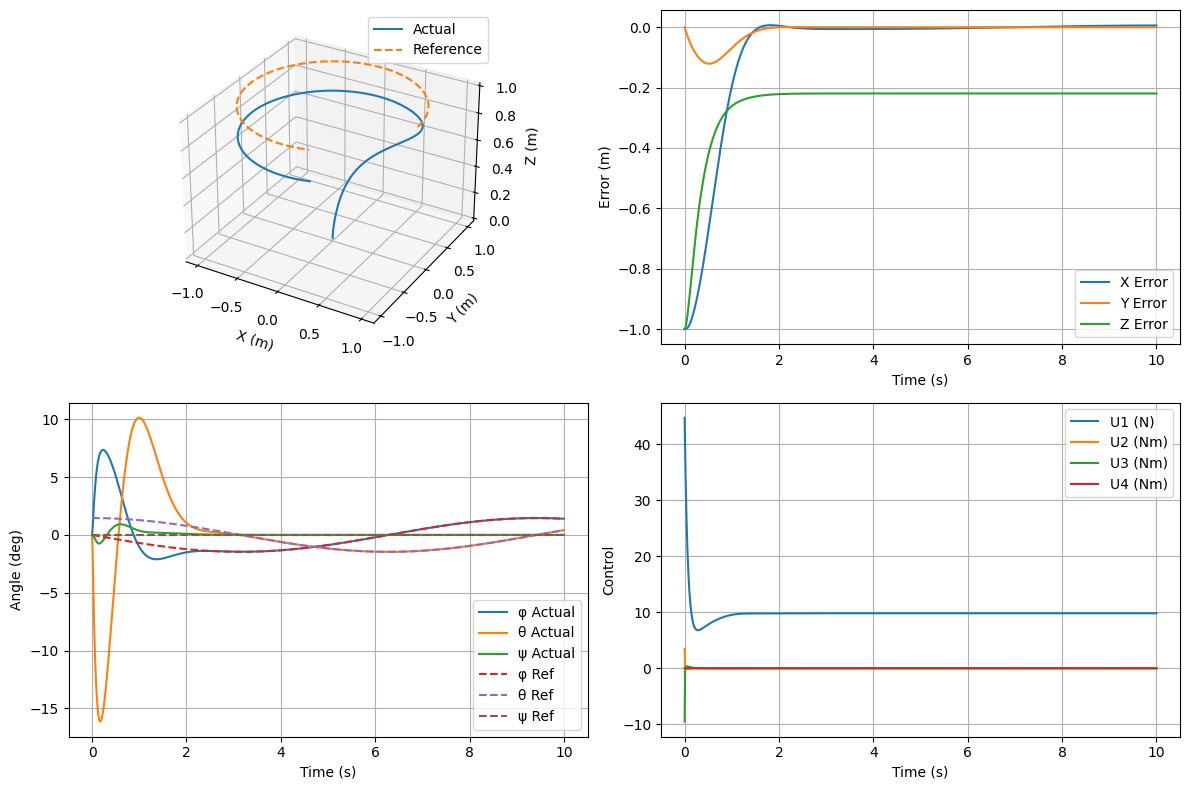

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Quadcopter dynamics (nonlinear)
def quadcopter_dynamics(state, t, u_func, quad):
    x, dx, y, dy, z, dz, phi, dphi, theta, dtheta, psi, dpsi = state
    m, Ixx, Iyy, Izz, g = quad.m, quad.Ixx, quad.Iyy, quad.Izz, quad.g

    # Control input
    U1, U2, U3, U4 = u_func(t, state)

    # Rotation matrix components
    cphi, sphi = np.cos(phi), np.sin(phi)
    ctheta, stheta = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    # Translational dynamics
    ddx = -(U1 / m) * (cphi * stheta * cpsi + sphi * spsi)
    ddy = -(U1 / m) * (cphi * stheta * spsi - sphi * cpsi)
    ddz = -g + (U1 / m) * cphi * ctheta

    # Rotational kinematics
    dphi_dt = dphi + dtheta * sphi * np.tan(theta) + dpsi * cphi * np.tan(theta)
    dtheta_dt = dtheta * cphi - dpsi * sphi
    dpsi_dt = dtheta * sphi / ctheta + dpsi * cphi / ctheta

    # Rotational dynamics
    ddphi = (U2 / Ixx) + ((Iyy - Izz) / Ixx) * dtheta * dpsi
    ddtheta = (U3 / Iyy) + ((Izz - Ixx) / Iyy) * dphi * dpsi
    ddpsi = (U4 / Izz) + ((Ixx - Iyy) / Izz) * dphi * dtheta

    return [dx, ddx, dy, ddy, dz, ddz, dphi_dt, ddphi, dtheta_dt, ddtheta, dpsi_dt, ddpsi]

# Reference trajectory (circular)
def generate_trajectory(t, r=1.0, omega=0.5, z0=1.0):
    x_d = r * np.cos(omega * t)
    y_d = r * np.sin(omega * t)
    z_d = z0 * np.ones_like(t)
    dx_d = -r * omega * np.sin(omega * t)
    dy_d = r * omega * np.cos(omega * t)
    dz_d = np.zeros_like(t)
    ddx_d = -r * omega**2 * np.cos(omega * t)
    ddy_d = -r * omega**2 * np.sin(omega * t)
    ddz_d = np.zeros_like(t)
    phi_d = ddy_d / quad.g
    theta_d = -ddx_d / quad.g
    psi_d = np.zeros_like(t)
    dphi_d = (-r * omega**3 * np.cos(omega * t)) / quad.g
    dtheta_d = (r * omega**3 * np.sin(omega * t)) / quad.g
    dpsi_d = np.zeros_like(t)
    ddphi_d = (r * omega**4 * np.sin(omega * t)) / quad.g
    ddtheta_d = (-r * omega**4 * np.cos(omega * t)) / quad.g
    ddpsi_d = np.zeros_like(t)
    return (x_d, dx_d, y_d, dy_d, z_d, dz_d, phi_d, dphi_d, theta_d, dtheta_d, psi_d, dpsi_d,
            ddx_d, ddy_d, ddz_d, ddphi_d, ddtheta_d, ddpsi_d)

# Control function
def control_input(t, state, controller, traj_data):
    quad.states = state
    t_idx = np.argmin(np.abs(t_vec - t))
    # Extract reference states and accelerations for current time
    ref_states = np.array([traj_data[i][t_idx] for i in range(12)])
    ref_acc = np.array([traj_data[i][t_idx] for i in range(12, 18)])
    return controller.get_actions(ref_states)

# Simulation parameters
quad = Quadcopter(m=1.0, Ixx=0.01, Iyy=0.01, Izz=0.02, g=9.81)
controller = LQRQuadcopterController(quad)
t_vec = np.linspace(0, 10, 1000)
dt = t_vec[1] - t_vec[0]

# Generate trajectory
traj_data = generate_trajectory(t_vec)

# Initial state
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Simulate
def u_func(t, state):
    return control_input(t, state, controller, traj_data)

sol = odeint(quadcopter_dynamics, x0, t_vec, args=(u_func, quad))

# Extract results
x, y, z = sol[:, 0], sol[:, 2], sol[:, 4]
phi, theta, psi = sol[:, 6], sol[:, 8], sol[:, 10]
x_d, y_d, z_d = traj_data[0], traj_data[2], traj_data[4]
phi_d, theta_d, psi_d = traj_data[6], traj_data[8], traj_data[10]

# Compute control inputs
u = np.array([control_input(t, sol[i], controller, traj_data) for i, t in enumerate(t_vec)])

# Plotting
plt.figure(figsize=(12, 8))

# 3D Trajectory
ax = plt.subplot(2, 2, 1, projection='3d')
ax.plot(x, y, z, label='Actual')
ax.plot(x_d, y_d, z_d, '--', label='Reference')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()

# Position Errors
plt.subplot(2, 2, 2)
plt.plot(t_vec, x - x_d, label='X Error')
plt.plot(t_vec, y - y_d, label='Y Error')
plt.plot(t_vec, z - z_d, label='Z Error')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.legend()
plt.grid()

# Attitude
plt.subplot(2, 2, 3)
plt.plot(t_vec, np.degrees(phi), label='φ Actual')
plt.plot(t_vec, np.degrees(theta), label='θ Actual')
plt.plot(t_vec, np.degrees(psi), label='ψ Actual')
plt.plot(t_vec, np.degrees(phi_d), '--', label='φ Ref')
plt.plot(t_vec, np.degrees(theta_d), '--', label='θ Ref')
plt.plot(t_vec, np.degrees(psi_d), '--', label='ψ Ref')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.grid()

# Control Inputs
plt.subplot(2, 2, 4)
plt.plot(t_vec, u[:, 0], label='U1 (N)')
plt.plot(t_vec, u[:, 1], label='U2 (Nm)')
plt.plot(t_vec, u[:, 2], label='U3 (Nm)')
plt.plot(t_vec, u[:, 3], label='U4 (Nm)')
plt.xlabel('Time (s)')
plt.ylabel('Control')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

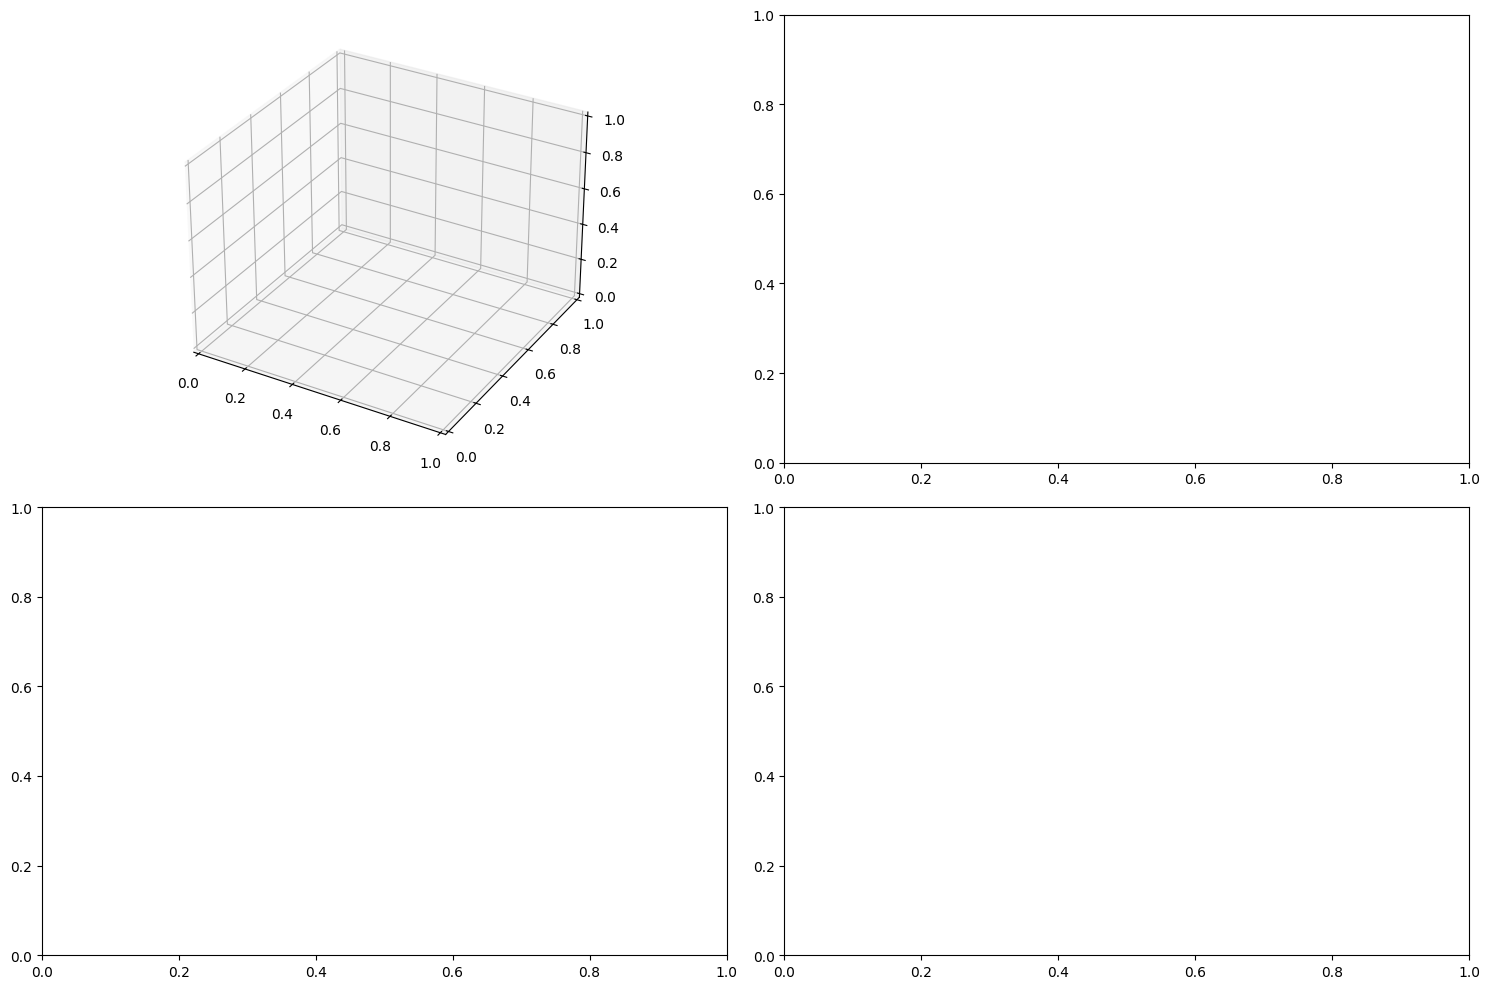

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

# Quadcopter dynamics (nonlinear)
def quadcopter_dynamics(state, t, u_func, quad):
    x, dx, y, dy, z, dz, phi, dphi, theta, dtheta, psi, dpsi = state
    m, Ixx, Iyy, Izz, g = quad.m, quad.Ixx, quad.Iyy, quad.Izz, quad.g

    # Control input
    U1, U2, U3, U4 = u_func(t, state)

    # Rotation matrix components
    cphi, sphi = np.cos(phi), np.sin(phi)
    ctheta, stheta = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    # Translational dynamics
    ddx = -(U1 / m) * (cphi * stheta * cpsi + sphi * spsi)
    ddy = -(U1 / m) * (cphi * stheta * spsi - sphi * cpsi)
    ddz = -g + (U1 / m) * cphi * ctheta

    # Rotational kinematics
    dphi_dt = dphi + dtheta * sphi * np.tan(theta) + dpsi * cphi * np.tan(theta)
    dtheta_dt = dtheta * cphi - dpsi * sphi
    dpsi_dt = dtheta * sphi / ctheta + dpsi * cphi / ctheta

    # Rotational dynamics
    ddphi = (U2 / Ixx) + ((Iyy - Izz) / Ixx) * dtheta * dpsi
    ddtheta = (U3 / Iyy) + ((Izz - Ixx) / Iyy) * dphi * dpsi
    ddpsi = (U4 / Izz) + ((Ixx - Iyy) / Izz) * dphi * dtheta

    return [dx, ddx, dy, ddy, dz, ddz, dphi_dt, ddphi, dtheta_dt, ddtheta, dpsi_dt, ddpsi]

# Reference trajectory (circular)
def generate_trajectory(t, r=1.0, omega=0.5, z0=1.0):
    x_d = r * np.cos(omega * t)
    y_d = r * np.sin(omega * t)
    z_d = z0 * np.ones_like(t)
    dx_d = -r * omega * np.sin(omega * t)
    dy_d = r * omega * np.cos(omega * t)
    dz_d = np.zeros_like(t)
    ddx_d = -r * omega**2 * np.cos(omega * t)
    ddy_d = -r * omega**2 * np.sin(omega * t)
    ddz_d = np.zeros_like(t)
    phi_d = ddy_d / quad.g
    theta_d = -ddx_d / quad.g
    psi_d = np.zeros_like(t)
    dphi_d = (-r * omega**3 * np.cos(omega * t)) / quad.g
    dtheta_d = (r * omega**3 * np.sin(omega * t)) / quad.g
    dpsi_d = np.zeros_like(t)
    ddphi_d = (r * omega**4 * np.sin(omega * t)) / quad.g
    ddtheta_d = (-r * omega**4 * np.cos(omega * t)) / quad.g
    ddpsi_d = np.zeros_like(t)
    return (x_d, dx_d, y_d, dy_d, z_d, dz_d, phi_d, dphi_d, theta_d, dtheta_d, psi_d, dpsi_d,
            ddx_d, ddy_d, ddz_d, ddphi_d, ddtheta_d, ddpsi_d)

# Control function
def control_input(t, state, controller, traj_data):
    quad.states = state
    t_idx = np.argmin(np.abs(t_vec - t))
    # Extract reference states and accelerations for current time
    ref_states = np.array([traj_data[i][t_idx] for i in range(12)])
    ref_acc = np.array([traj_data[i][t_idx] for i in range(12, 18)])
    return controller.get_actions(ref_states)

# Simulation parameters
quad = Quadcopter(m=1.0, Ixx=0.01, Iyy=0.01, Izz=0.02, g=9.81)
controller = LQRQuadcopterController(quad)
t_vec = np.linspace(0, 10, 1000)
dt = t_vec[1] - t_vec[0]

# Generate trajectory
traj_data = generate_trajectory(t_vec)

# Initial state
x0 = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0])

# Simulate
def u_func(t, state):
    return control_input(t, state, controller, traj_data)

sol = odeint(quadcopter_dynamics, x0, t_vec, args=(u_func, quad))

# Extract results
x, y, z = sol[:, 0], sol[:, 2], sol[:, 4]
phi, theta, psi = sol[:, 6], sol[:, 8], sol[:, 10]
x_d, y_d, z_d = traj_data[0], traj_data[2], traj_data[4]
phi_d, theta_d, psi_d = traj_data[6], traj_data[8], traj_data[10]

# Compute control inputs
u = np.array([control_input(t, sol[i], controller, traj_data) for i, t in enumerate(t_vec)])

# Create figure for animation
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Initialize plot elements
def init():
    # 3D Trajectory
    ax1.clear()
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(0, 2)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Trajectory')

    # Position Errors
    ax2.clear()
    ax2.set_xlim(0, 10)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Error (m)')
    ax2.set_title('Position Errors')
    ax2.grid()

    # Attitude
    ax3.clear()
    ax3.set_xlim(0, 10)
    ax3.set_ylim(-30, 30)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Angle (deg)')
    ax3.set_title('Attitude')
    ax3.grid()

    # Control Inputs
    ax4.clear()
    ax4.set_xlim(0, 10)
    ax4.set_ylim(-5, 15)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Control')
    ax4.set_title('Control Inputs')
    ax4.grid()

    return fig,

# Animation update function
def update(frame):
    # Select every 10th frame for smoother animation
    frame = frame * 10
    if frame >= len(t_vec):
        frame = len(t_vec) - 1

    # Clear axes
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()

    # 3D Trajectory
    ax1.plot(x_d[:frame+1], y_d[:frame+1], z_d[:frame+1], '--', label='Reference', color='gray')
    ax1.plot(x[:frame+1], y[:frame+1], z[:frame+1], 'b-', label='Actual')

    # Current position and orientation
    current_x, current_y, current_z = x[frame], y[frame], z[frame]
    current_phi, current_theta, current_psi = phi[frame], theta[frame], psi[frame]

    # Draw quadcopter orientation
    arrow_length = 0.2
    # X-axis (red)
    x_end = current_x + arrow_length * np.cos(current_psi) * np.cos(current_theta)
    y_end = current_y + arrow_length * np.sin(current_psi) * np.cos(current_theta)
    z_end = current_z + arrow_length * np.sin(current_theta)
    arrow_x = Arrow3D([current_x, x_end], [current_y, y_end], [current_z, z_end],
                     mutation_scale=10, lw=1, arrowstyle="-|>", color="r")
    ax1.add_artist(arrow_x)

    # Y-axis (green)
    x_end = current_x + arrow_length * (-np.sin(current_psi) * np.cos(current_phi) +
                                      np.cos(current_psi) * np.sin(current_theta) * np.sin(current_phi))
    y_end = current_y + arrow_length * (np.cos(current_psi) * np.cos(current_phi) +
                                      np.sin(current_psi) * np.sin(current_theta) * np.sin(current_phi))
    z_end = current_z + arrow_length * (-np.cos(current_theta) * np.sin(current_phi))
    arrow_y = Arrow3D([current_x, x_end], [current_y, y_end], [current_z, z_end],
                     mutation_scale=10, lw=1, arrowstyle="-|>", color="g")
    ax1.add_artist(arrow_y)

    # Z-axis (blue)
    x_end = current_x + arrow_length * (np.sin(current_psi) * np.sin(current_phi) +
                                      np.cos(current_psi) * np.sin(current_theta) * np.cos(current_phi))
    y_end = current_y + arrow_length * (-np.cos(current_psi) * np.sin(current_phi) +
                                      np.sin(current_psi) * np.sin(current_theta) * np.cos(current_phi))
    z_end = current_z + arrow_length * (np.cos(current_theta) * np.cos(current_phi))
    arrow_z = Arrow3D([current_x, x_end], [current_y, y_end], [current_z, z_end],
                     mutation_scale=10, lw=1, arrowstyle="-|>", color="b")
    ax1.add_artist(arrow_z)

    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_zlim(0, 2)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D Trajectory')
    ax1.legend()

    # Position Errors
    ax2.plot(t_vec[:frame+1], x[:frame+1] - x_d[:frame+1], label='X Error')
    ax2.plot(t_vec[:frame+1], y[:frame+1] - y_d[:frame+1], label='Y Error')
    ax2.plot(t_vec[:frame+1], z[:frame+1] - z_d[:frame+1], label='Z Error')
    ax2.set_xlim(0, 10)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Error (m)')
    ax2.set_title('Position Errors')
    ax2.legend()
    ax2.grid()

    # Attitude
    ax3.plot(t_vec[:frame+1], np.degrees(phi[:frame+1]), label='φ Actual')
    ax3.plot(t_vec[:frame+1], np.degrees(theta[:frame+1]), label='θ Actual')
    ax3.plot(t_vec[:frame+1], np.degrees(psi[:frame+1]), label='ψ Actual')
    ax3.plot(t_vec[:frame+1], np.degrees(phi_d[:frame+1]), '--', label='φ Ref')
    ax3.plot(t_vec[:frame+1], np.degrees(theta_d[:frame+1]), '--', label='θ Ref')
    ax3.plot(t_vec[:frame+1], np.degrees(psi_d[:frame+1]), '--', label='ψ Ref')
    ax3.set_xlim(0, 10)
    ax3.set_ylim(-30, 30)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Angle (deg)')
    ax3.set_title('Attitude')
    ax3.legend()
    ax3.grid()

    # Control Inputs
    ax4.plot(t_vec[:frame+1], u[:frame+1, 0], label='U1 (N)')
    ax4.plot(t_vec[:frame+1], u[:frame+1, 1], label='U2 (Nm)')
    ax4.plot(t_vec[:frame+1], u[:frame+1, 2], label='U3 (Nm)')
    ax4.plot(t_vec[:frame+1], u[:frame+1, 3], label='U4 (Nm)')
    ax4.set_xlim(0, 10)
    ax4.set_ylim(-5, 15)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Control')
    ax4.set_title('Control Inputs')
    ax4.legend()
    ax4.grid()

    plt.tight_layout()
    return fig,

# Create animation
ani = FuncAnimation(fig, update, frames=len(t_vec)//10, init_func=init, blit=False, interval=50)

plt.tight_layout()
plt.show()

# To save the animation (uncomment if needed)
ani.save('quadcopter_tracking.mp4', writer='ffmpeg', fps=30, dpi=300)